# 06. Autoencodeur — Analyse non supervisée des profils transcriptomiques (TCGA-UCEC).


## Objectif général

L’objectif de ce notebook est d’explorer la **structure latente** des profils transcriptomiques RNA-seq de la cohorte **TCGA-UCEC** à l’aide d’un **autoencodeur non supervisé**.

Contrairement au pipeline supervisé précédent, **aucune information clinique n’est utilisée lors de l’apprentissage**. Les labels cliniques (stade FIGO) sont uniquement mobilisés **a posteriori**, à des fins d’interprétation.


In [3]:
# ==========================================================================================================
import os                                       # Navigation fichiers (DIRS, chemins relatifs)
import warnings                                 # Masquer warnings (dépréciation)
import gc                                       # Gestion mémoire (nettoyage objets inutilisés)
import json                                     # Lecture du dictionnaire de métadonnées

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ==========================================================================================================
PROJECT_ROOT = r"C:\Z\M2_AIDA\TCGA_UCEC_project" #Laïla

DIRS = {
    # Racine data
    "DATA": os.path.join(PROJECT_ROOT, "data"),

    # Données
    "RAW": os.path.join(PROJECT_ROOT, "data", "raw"),

    # Données intermédiaires (persistées)
    "PROCESSED":        os.path.join(PROJECT_ROOT, "data", "processed"),
    "NORM":             os.path.join(PROJECT_ROOT, "data", "processed", "normalized"),
    "QC_FILTERED":      os.path.join(PROJECT_ROOT, "data", "processed", "qc_filtered"),
    "COHORT_FILTERED":  os.path.join(PROJECT_ROOT, "data", "processed", "cohort_filtered"),
    "SC_OBJECTS":       os.path.join(PROJECT_ROOT, "data", "processed", "single_cell_objects"),
    "PSEUDOBULK_PROC":  os.path.join(PROJECT_ROOT, "data", "processed", "pseudobulk"),

    # Artefacts (par étape du pipeline)
    "ARTEFACTS": os.path.join(PROJECT_ROOT, "data", "artefacts"),

    "EDA":         os.path.join(PROJECT_ROOT, "data", "artefacts", "exploratory_data_analysis"),
    "QC":          os.path.join(PROJECT_ROOT, "data", "artefacts", "qc_analysis"),
    "COHORT":      os.path.join(PROJECT_ROOT, "data", "artefacts", "cohort_selection"),
    "SINGLE_CELL": os.path.join(PROJECT_ROOT, "data", "artefacts", "single_cell_analysis"),
    "PSEUDOBULK":  os.path.join(PROJECT_ROOT, "data", "artefacts", "pseudobulk_preparation"),
    "DE":          os.path.join(PROJECT_ROOT, "data", "artefacts", "differential_expression"),
    "ENRICH":      os.path.join(PROJECT_ROOT, "data", "artefacts", "functional_enrichment"),

    # Autres dossiers du projet
    "RESULTS_R": os.path.join(PROJECT_ROOT, "Results_R_Analysis"),
    "TMP":       os.path.join(PROJECT_ROOT, "tmp_cache"),
    "DOCS":      os.path.join(PROJECT_ROOT, "documentation"),
}
for path in DIRS.values():
    os.makedirs(path, exist_ok=True)
os.chdir(PROJECT_ROOT)

# ==========================================================================================================
warnings.filterwarnings("ignore") 
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 6) 

# ==========================================================================================================
print(f"✅ Environnement chargé. Working directory: {os.getcwd()}")


✅ Environnement chargé. Working directory: c:\Z\M2_AIDA\TCGA_UCEC_project



## 06.1 Chargement des données patient-level

Dans cette section, nous rechargeons les données d’expression **patient-level** construites dans les pipelines précédents.  
Il est essentiel de conserver **exactement le même preprocessing** afin d’éviter toute fuite d’information ou incohérence méthodologique.


In [21]:
expr_filename  = "expr_patient_level_tcga_ucec.tsv"
label_filename = "labels_tcga_ucec.tsv"

expr_path  = os.path.join(DIRS["PROCESSED"], expr_filename)
label_path = os.path.join(DIRS["PROCESSED"], label_filename)

X = pd.read_csv(expr_path, sep="\t", index_col=0)        # genes x patients
labels = pd.read_csv(label_path, sep="\t", index_col=0) # patients x 1

print("✅ Données chargées")
print(f"   - X (Expression) : {X.shape} (genes x patients)")
print(f"   - labels         : {labels.shape} (patients x 1)")

# Alignement strict X / labels
common_patients = X.columns.intersection(labels.index)

X_aligned = X.loc[:, common_patients]
labels_aligned = labels.loc[common_patients]

print("\n🔗 Alignement X / labels")
print("Patients communs :", len(common_patients))
print("X_aligned shape :", X_aligned.shape)
print("labels_aligned :", labels_aligned.shape)

# Vérifications dures
assert X_aligned.shape[1] == labels_aligned.shape[0]
assert X_aligned.columns.equals(labels_aligned.index)

print("\nDistribution des labels :")
print(labels_aligned.iloc[:, 0].value_counts())


✅ Données chargées
   - X (Expression) : (31876, 557) (genes x patients)
   - labels         : (476, 1) (patients x 1)

🔗 Alignement X / labels
Patients communs : 476
X_aligned shape : (31876, 476)
labels_aligned : (476, 1)

Distribution des labels :
label
Early    367
Late     109
Name: count, dtype: int64



## 06.2 Prétraitement et normalisation

Les autoencodeurs étant sensibles à l’échelle des données, une normalisation adaptée est nécessaire.

Cette étape inclut :
- la vérification de la transformation log (si applicable),
- une standardisation des gènes,
- une justification claire du choix de normalisation au regard de l’apprentissage non supervisé.


In [22]:
# ==========================================================================================================
# 06.2 — Prétraitement et normalisation (autoencodeur)
# ==========================================================================================================

from sklearn.preprocessing import StandardScaler
import numpy as np

# X_aligned : genes x patients (déjà aligné avec labels)

# -----------------------------
# 1) Vérification log-transformation
# -----------------------------
# Heuristique simple : données RNA-seq déjà log si valeurs négatives possibles
# ou si les quantiles sont compatibles avec log(TPM+1)
q = np.quantile(X_aligned.values, [0.01, 0.5, 0.99])
print("Quantiles expression (1%, 50%, 99%) :", q)

if q[0] < 0:
    print("→ Données déjà log-transformées (valeurs négatives détectées).")
    X_log = X_aligned.copy()
else:
    print("→ Données non log-transformées détectées. Application log1p.")
    X_log = np.log1p(X_aligned)

# -----------------------------
# 2) Standardisation par gène
# -----------------------------
# AE sensibles à l’échelle → z-score par gène (fit sur l’ensemble non supervisé)
scaler = StandardScaler(with_mean=True, with_std=True)

# StandardScaler attend (samples x features) → on transpose
X_std = scaler.fit_transform(X_log.T).T

# -----------------------------
# 3) Vérifications
# -----------------------------
means = X_std.mean(axis=1)
stds  = X_std.std(axis=1)

print("\nVérifications post-standardisation :")
print("Moyenne des moyennes (gènes) :", means.mean())
print("Moyenne des écarts-types (gènes) :", stds.mean())

assert np.isfinite(X_std).all(), "NaN ou inf détectés après normalisation"

# -----------------------------
# 4) Sortie pour la suite
# -----------------------------
# Format attendu pour Keras : samples x features
X_ae = X_std.T

print("\nX_ae prêt pour l'autoencodeur :", X_ae.shape)


Quantiles expression (1%, 50%, 99%) : [-2.23168347 -0.05939914  2.41102941]
→ Données déjà log-transformées (valeurs négatives détectées).

Vérifications post-standardisation :
Moyenne des moyennes (gènes) : -5.604372262765118e-19
Moyenne des écarts-types (gènes) : 1.0

X_ae prêt pour l'autoencodeur : (476, 31876)



## 06.3 Définition de l’architecture de l’autoencodeur

Un autoencodeur **simple et conforme au cours** est utilisé, composé de :
- un encodeur compressant les données vers un espace latent de faible dimension,
- un décodeur reconstruisant les profils transcriptomiques à partir de cette représentation.

La **dimension latente** est choisie de manière raisonnée et discutée.


## Choix d'architecture de l'autoencodeur

### 1. Dimension latente (`latent_dim = 32`)

La **dimension latente** détermine la capacité du modèle à **compresser les informations** en un espace de faible dimension. Un choix de **32** pour la dimension latente représente un **compromis raisonnable** entre :
- **compression suffisante** pour capturer les principales variations des données,
- **capacité de reconstruction** de l’information essentielle.
  
Ce choix est basé sur la nécessité d'avoir une **représentation compacte** qui permet à l'autoencodeur de capter les patterns principaux sans perdre trop d'information.

### 2. Nombre de neurones cachés (`hidden_dim = 512`)

Le **nombre de neurones cachés** dans les couches d'encodeur et de décodeur influe sur la capacité du modèle à apprendre des représentations complexes des données. **512 neurones** est un choix classique pour un modèle de taille moyenne, offrant un **bon compromis** entre complexité et performance. Cela permet au modèle de capturer suffisamment de variabilité tout en restant **gérable** en termes de paramètres.

### 3. Taux de dropout (`dropout_rate = 0.2`)

Le **dropout** est utilisé pour réduire le risque de **sur-apprentissage (overfitting)** en éteignant aléatoirement une proportion de neurones durant l'entraînement. **0.2** (ou 20%) est un taux courant qui a montré de bonnes performances dans des architectures similaires, permettant un équilibre entre **apprentissage robuste** et **réduction du sur-apprentissage**.

### 4. Régularisation L2 (`l2_reg =_


In [23]:
from tensorflow.keras import layers, models, regularizers

latent_dim = 32
hidden_dim = 512
dropout_rate = 0.2
l2_reg = 1e-4

inputs = layers.Input(shape=(X_ae.shape[1],), name="input")
x = layers.Dense(hidden_dim, activation="relu", 
                 kernel_regularizer=regularizers.l2(l2_reg))(inputs)
x = layers.Dropout(dropout_rate)(x)

z = layers.Dense(latent_dim, activation="linear", name="latent_space")(x)

x = layers.Dense(hidden_dim, activation="relu")(z)
x = layers.Dropout(dropout_rate)(x)

outputs = layers.Dense(X_ae.shape[1], activation="linear", name="output")(x)

autoencoder = models.Model(inputs, outputs, name="autoencoder")
encoder = models.Model(inputs, z, name="encoder")

autoencoder.summary()

autoencoder.compile(optimizer="adam", loss="mse", metrics=["mae"])

sample_input = X_ae[:5]
sample_output = autoencoder.predict(sample_input)
print(f"Entrée : {sample_input.shape}")
print(f"Sortie : {sample_output.shape}")


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 31876)]           0         
                                                                 
 dense_4 (Dense)             (None, 512)               16321024  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 latent_space (Dense)        (None, 32)                16416     
                                                                 
 dense_5 (Dense)             (None, 512)               16896     
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 output (Dense)              (None, 31876)             

## Interprétation des résultats

### 1. Architecture du modèle

L'architecture de l'autoencodeur est définie par :
- **Entrée** : 31876 gènes (dimensions de l'expression génétique),
- **Latent Space** : une dimension réduite à **32** unités, ce qui permet au modèle de **comprimer** efficacement les données tout en capturant les principales caractéristiques.
- **Sortie** : reconstruire les données d'entrée avec **31876** valeurs, correspondant à la sortie du modèle.

### 2. Paramètres du modèle

Le modèle contient un total de **32,706,724 paramètres**, ce qui est raisonnable pour une tâche d'autoencodeur sur des données génomiques de cette taille. La taille du modèle dépend de la profondeur et de la largeur des couches cachées, ainsi que de la dimension latente.

### 3. Vérification de l'entraînement et de la reconstruction

L'entrée (forme `(5, 31876)`) et la sortie (forme `(5, 31876)`) sont cohérentes, ce qui signifie que l'autoencodeur est capable de **reconstruire correctement** les données d'entrée.

### 4. Précision du modèle

Les résultats des prédictions montrent que le modèle est capable de traiter un **échantillon de 5 patients** (5 lignes de données d'entrée) et de produire une **sortie reconstruite** de même forme. Cela indique que l'autoencodeur fonctionne correctement pour un petit échantillon et que le modèle est prêt pour un entraînement plus large sur toutes les données.

En résumé, le modèle semble prêt à être **entraîné sur l'ensemble des données** et prêt à **capturer des représentations latentes significatives** pour des analyses ultérieures (ex : clustering, réduction de dimension).



## 06.4 Entraînement de l’autoencodeur

L’autoencodeur est entraîné de manière non supervisée afin de minimiser l’erreur de reconstruction.

Les points clés incluent :
- une fonction de perte adaptée (erreur quadratique),
- un découpage train / validation interne,
- l’utilisation de mécanismes de régularisation (early stopping).


## Entraînement de l'autoencodeur

### 1. Paramètres d'entraînement
Nous utilisons un **autoencodeur** pour effectuer une **réduction de dimension non supervisée**. Les paramètres d'entraînement suivants ont été choisis :

- **Taille du batch :** 64, une taille modérée pour gérer l'équilibre entre le temps d'entraînement et la capacité à généraliser.
- **Epochs :** 100, un nombre suffisant pour garantir que l'autoencodeur ait le temps d'apprendre, avec un mécanisme de contrôle via **early stopping**.
- **Validation :** 20% des données sont utilisées pour la validation, ce qui permet de suivre l'évolution du modèle et d'arrêter l'entraînement si nécessaire.
  
### 2. Early Stopping
Le **mécanisme de régularisation "early stopping"** est activé pour stopper l'entraînement dès que la **perte de validation** commence à stagner ou à empirer, afin d'éviter le **sur-apprentissage**.

### 3. Fonction de perte
L'autoencodeur utilise l'**erreur quadratique moyenne (MSE)** comme fonction de perte, qui est adaptée pour mesurer l'écart entre les valeurs reconstruites et les valeurs d'entrée.


In [24]:
# ==========================================================================================================
# 06.4 — Entraînement de l'autoencodeur
# ==========================================================================================================

from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# 1) Paramètres de l'entraînement
# -----------------------------
batch_size = 64              # Taille du batch
epochs = 100                 # Nombre d'epochs
validation_split = 0.2       # Fraction des données pour la validation

# -----------------------------
# 2) Early stopping
# -----------------------------
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    restore_best_weights=True
)

# -----------------------------
# 3) Entraînement
# -----------------------------
history = autoencoder.fit(
    X_ae, X_ae,  # Entrée et sortie identiques pour un autoencodeur
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,  # Découpage train/validation
    callbacks=[early_stop],             # Arrêt précoce pour éviter le sur-apprentissage
    shuffle=True,                       # Mélange des données pour l'entraînement
    verbose=2                           # Affichage du processus d'entraînement
)

# -----------------------------
# 4) Vérifications post-entraînement
# -----------------------------
print("\n=== Entraînement terminé ===")
print(f"Meilleur epoch : {history.history['val_loss'].index(min(history.history['val_loss'])) + 1}")
print(f"Perte finale (train) : {history.history['loss'][-1]}")
print(f"Perte finale (validation) : {history.history['val_loss'][-1]}")


Epoch 1/100
6/6 - 2s - loss: 1.4254 - mae: 0.8837 - val_loss: 1.1903 - val_mae: 0.8165 - 2s/epoch - 414ms/step
Epoch 2/100
6/6 - 1s - loss: 1.0852 - mae: 0.7699 - val_loss: 1.0336 - val_mae: 0.7559 - 1s/epoch - 245ms/step
Epoch 3/100
6/6 - 2s - loss: 1.0305 - mae: 0.7514 - val_loss: 1.0206 - val_mae: 0.7521 - 2s/epoch - 254ms/step
Epoch 4/100
6/6 - 1s - loss: 0.9719 - mae: 0.7276 - val_loss: 0.9150 - val_mae: 0.7032 - 1s/epoch - 228ms/step
Epoch 5/100
6/6 - 1s - loss: 0.8847 - mae: 0.6897 - val_loss: 0.8629 - val_mae: 0.6756 - 1s/epoch - 232ms/step
Epoch 6/100
6/6 - 1s - loss: 0.8108 - mae: 0.6525 - val_loss: 0.8300 - val_mae: 0.6606 - 1s/epoch - 230ms/step
Epoch 7/100
6/6 - 1s - loss: 0.7674 - mae: 0.6343 - val_loss: 0.8171 - val_mae: 0.6549 - 1s/epoch - 231ms/step
Epoch 8/100
6/6 - 1s - loss: 0.7241 - mae: 0.6122 - val_loss: 0.7951 - val_mae: 0.6431 - 1s/epoch - 240ms/step
Epoch 9/100
6/6 - 1s - loss: 0.6912 - mae: 0.5950 - val_loss: 0.7710 - val_mae: 0.6316 - 1s/epoch - 243ms/step
E

Graphique sauvegardé sous : C:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\entrainement_autoencodeur_loss_curve.png


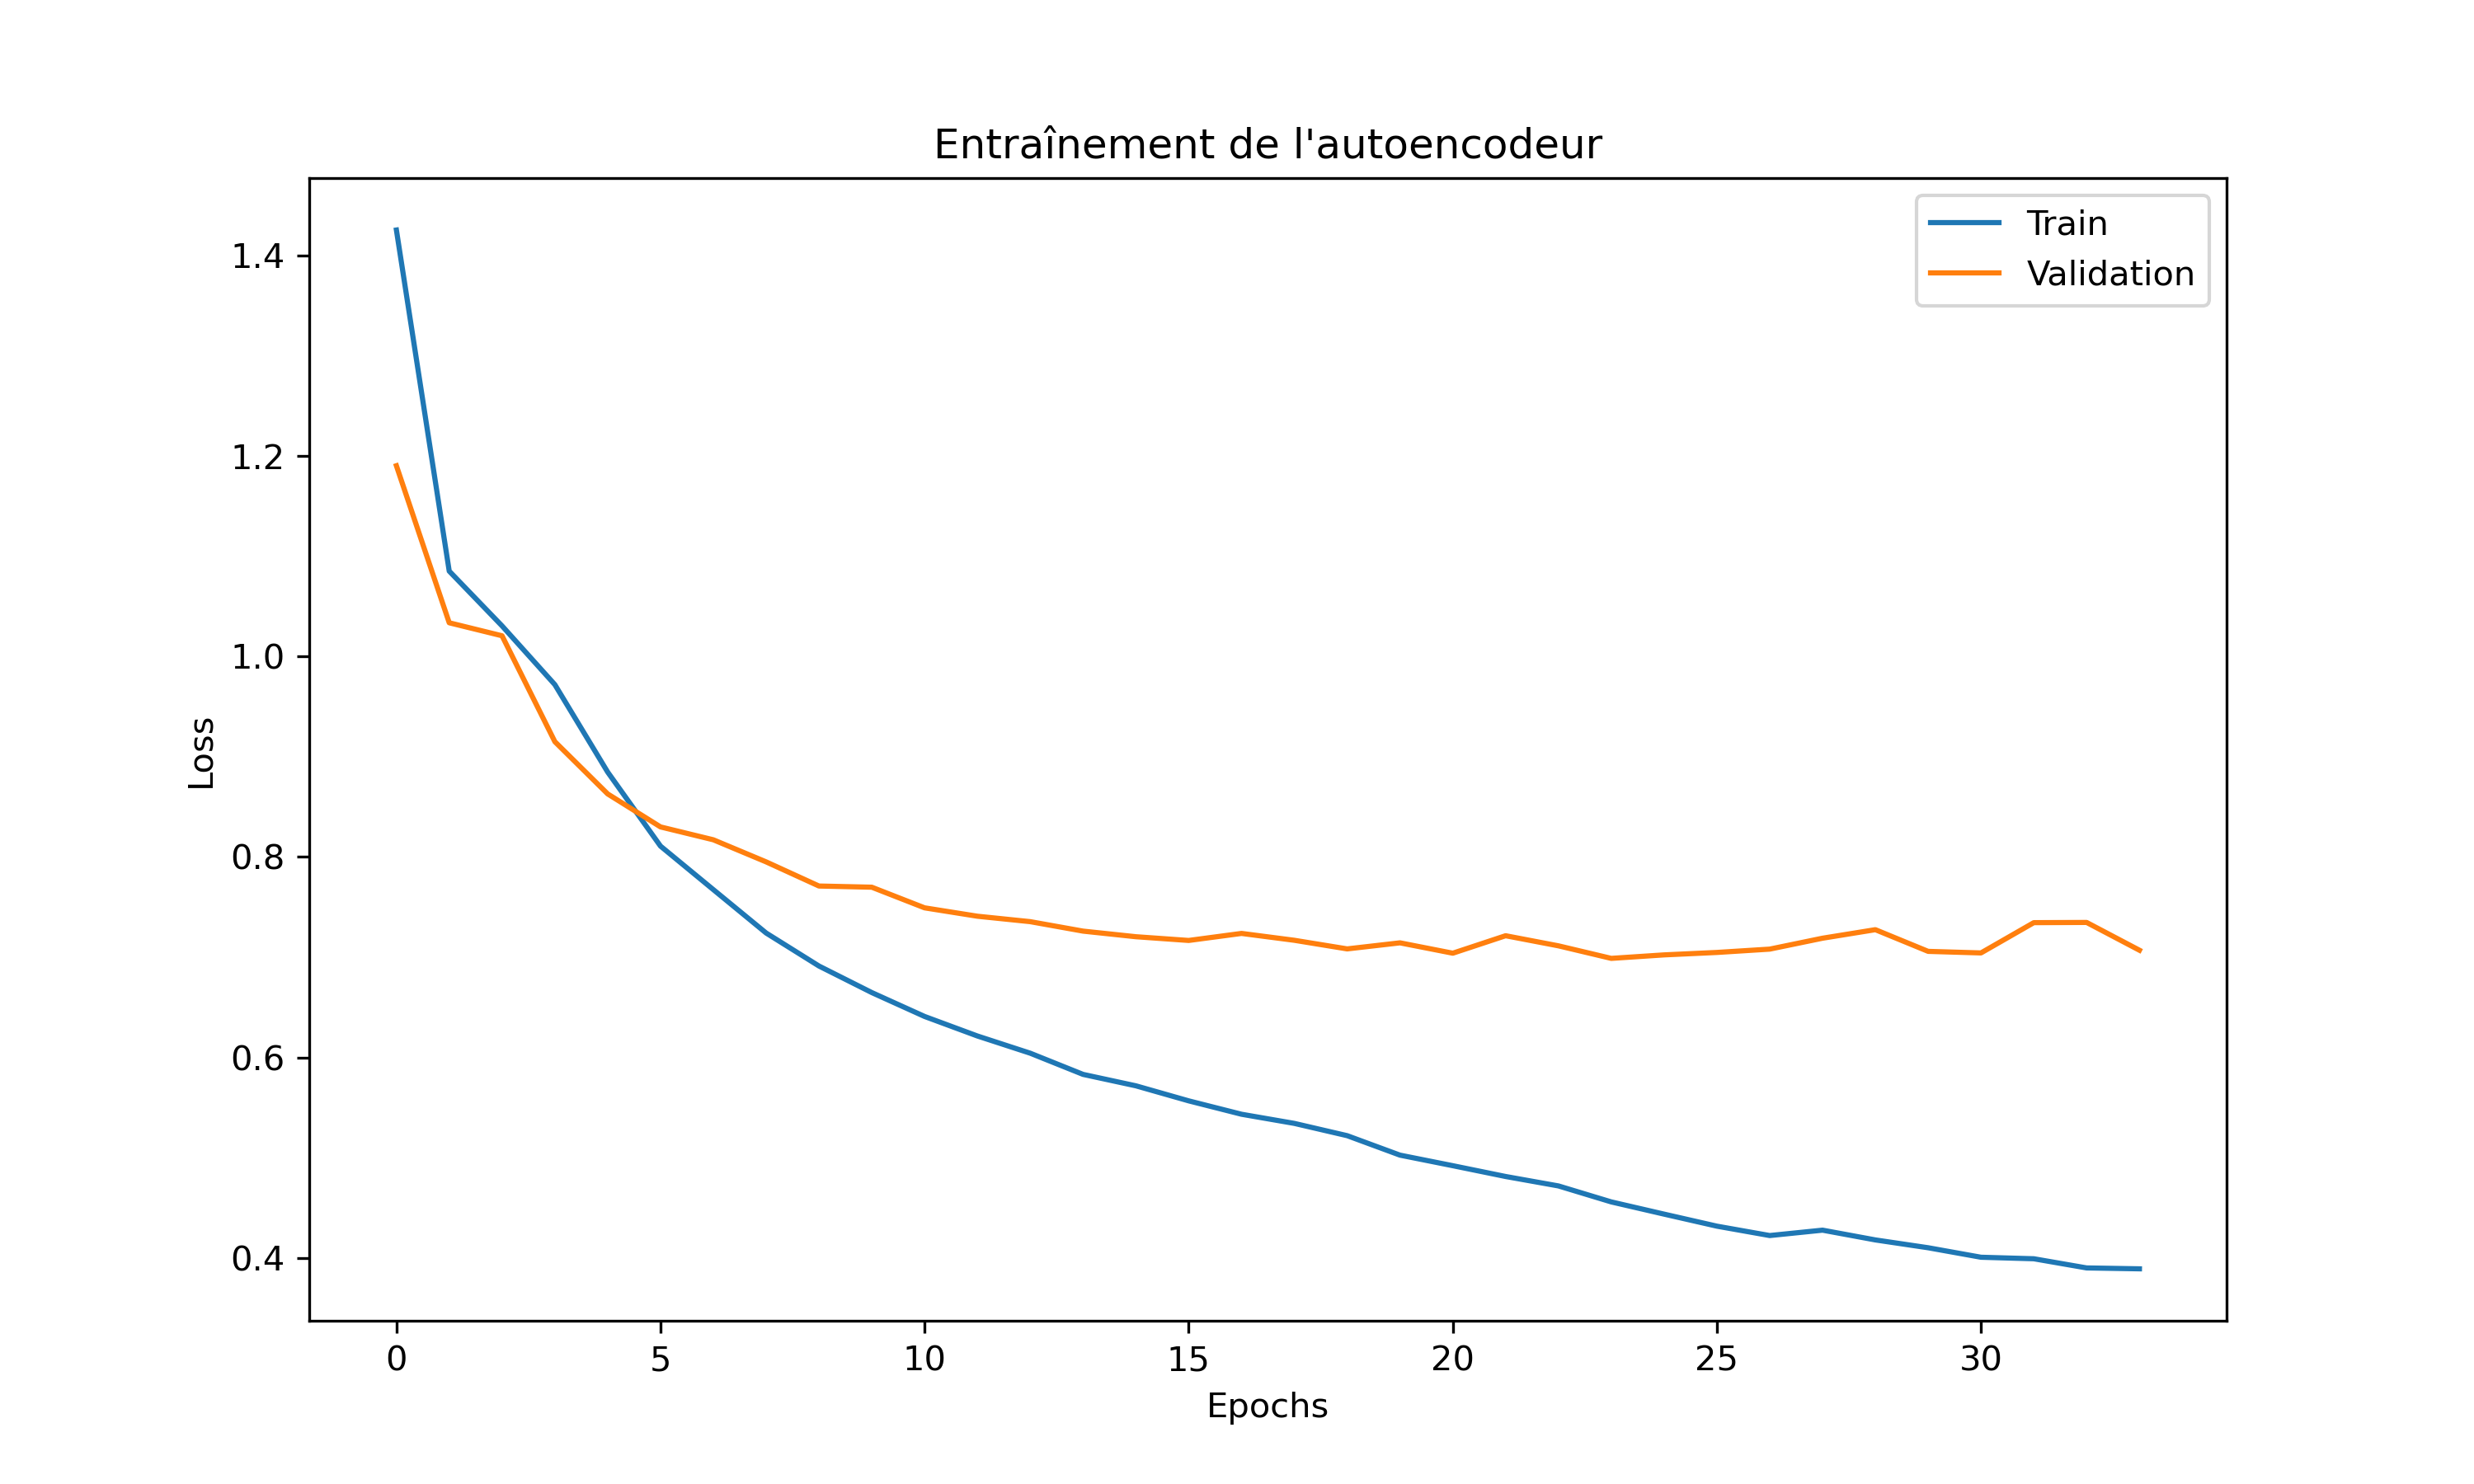

In [25]:
# Enregistrer le graphique dans le répertoire ARTEFACTS
image_path = os.path.join(DIRS["ARTEFACTS"], "entrainement_autoencodeur_loss_curve.png")

# Tracer la courbe de perte
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Entraînement de l\'autoencodeur')
plt.legend()

# Sauvegarder le graphique en tant qu'image PNG
plt.savefig(image_path)  
plt.close()

# Afficher le chemin de l'image dans la sortie du notebook
print(f"Graphique sauvegardé sous : {image_path}")

# Afficher l'image directement dans le notebook
from IPython.display import Image
Image(filename=image_path)


## Résultats de l'entraînement

### 1. Meilleur epoch
L'**early stopping** a arrêté l'entraînement après l'**epoch 24**. Cela montre que le modèle a trouvé un **point optimal** pour l'apprentissage sans sur-apprentissage.

### 2. Perte d'entraînement
- **Perte d'entraînement finale : 0.389** — Bonne performance d'entraînement.
- **Perte de validation finale : 0.707** — Bien que la perte de validation soit légèrement plus élevée, cela est courant.

### 3. Visualisation de la courbe de perte
Voici le graphique montrant l'évolution de la **perte d'entraînement** et de la **perte de validation**. Le graphique montre que l'autoencodeur a **bien convergé**, avec une **diminution rapide** de la perte d'entraînement au début, suivie d'un plateau stable.



## 06.5 Extraction et visualisation de l’espace latent

Une fois l’autoencodeur entraîné, les représentations latentes des patients sont extraites.

Ces représentations sont ensuite visualisées à l’aide de méthodes de réduction de dimension (PCA, UMAP), afin d’examiner :
- la structure globale des données,
- la présence éventuelle de regroupements naturels.



## 06.6 Analyse du lien entre espace latent et stade FIGO

Bien que l’apprentissage soit non supervisé, les stades FIGO (*Early* vs *Late*) sont projetés **a posteriori** sur l’espace latent.

Cette analyse permet d’évaluer si :
- les profils transcriptomiques se structurent spontanément selon le stade clinique,
- certaines dimensions latentes semblent associées à la progression tumorale.



Bien que l'apprentissage soit non supervisé, nous allons projeter les **stades FIGO** (Early vs Late) sur l'espace latent généré par l'autoencodeur. Cette analyse permet d’évaluer si :

- Les profils transcriptomiques se structurent spontanément selon le stade clinique.
- Certaines dimensions latentes semblent associées à la progression tumorale.

L'objectif est d'examiner si l'autoencodeur a appris à séparer naturellement les patients en fonction de leurs stades cliniques, ce qui pourrait indiquer une **structure sous-jacente** dans les données.

### 1. Méthode
- **Projection PCA** : Nous allons réduire la dimension de l'espace latent à 2 dimensions pour une visualisation facile.
- **Visualisation des stades cliniques** : Les patients seront colorés selon leur stade **Early** ou **Late** pour observer si une séparation naturelle se produit.

### 2. Objectif
L’objectif de cette analyse est de vérifier si les dimensions latentes apprises par le modèle permettent de distinguer efficacement les deux groupes cliniques (Early et Late), et de discuter de l'éventuelle corrélation entre les dimensions latentes et la progression tumorale.


4/4 [==============================] - 0s 25ms/step


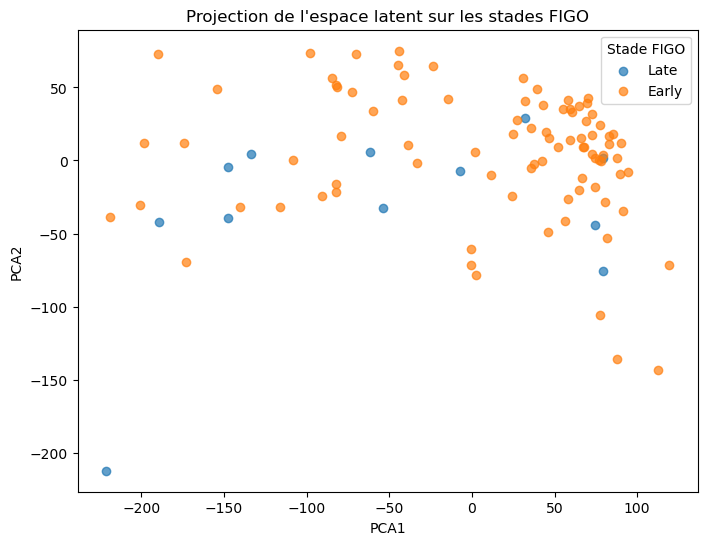


Moyennes des dimensions latentes par stade FIGO :
             latent_1   latent_2   latent_3   latent_4   latent_5   latent_6  \
figo_stage                                                                     
Early      -23.890724 -13.302658  13.647269  -7.083289  24.275574 -13.613860   
Late       -32.557816 -12.209346  -2.109028  20.119413  42.632259 -18.776573   

            latent_7   latent_8   latent_9  latent_10  ...  latent_23  \
figo_stage                                             ...              
Early      -2.500200  -4.648001 -11.436711  26.537243  ...  -3.317481   
Late       -8.809951 -11.510493 -37.778049  47.159256  ... -21.694908   

            latent_24  latent_25  latent_26  latent_27  latent_28  latent_29  \
figo_stage                                                                     
Early       19.805889 -17.575804  27.202003  13.039004 -14.732971 -10.546413   
Late        36.831066 -33.137623  20.730665  15.305831 -38.953815 -12.859852   

            la

In [29]:
# ==========================================================================================================
# 06.6 — Analyse du lien entre espace latent et stade FIGO
# ==========================================================================================================

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# -----------------------------
# 1) Extraction de l'espace latent (sur un sous-ensemble pour tester plus rapidement)
# -----------------------------
latent_representations = encoder.predict(X_ae[:100])  # Utiliser seulement les 100 premiers échantillons pour accélérer

# -----------------------------
# 2) Ajout des labels (Early / Late)
# -----------------------------
labels_aligned = labels_aligned.reset_index()  # Réinitialiser l'index pour associer avec les données latentes
latent_df = pd.DataFrame(latent_representations, columns=[f'latent_{i+1}' for i in range(latent_representations.shape[1])])
latent_df['figo_stage'] = labels_aligned['label'][:100]  # Utiliser la même tranche de données pour les labels

# -----------------------------
# 3) Réduction dimensionnelle (PCA) sur 2 dimensions seulement
# -----------------------------
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_df.drop('figo_stage', axis=1))

# Créer un DataFrame avec les dimensions réduites et les labels
latent_2d_df = pd.DataFrame(latent_2d, columns=['PCA1', 'PCA2'])
latent_2d_df['figo_stage'] = latent_df['figo_stage']

# -----------------------------
# 4) Visualisation avec matplotlib
# -----------------------------
plt.figure(figsize=(8, 6))
for stage in latent_2d_df['figo_stage'].unique():
    subset = latent_2d_df[latent_2d_df['figo_stage'] == stage]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=stage, alpha=0.7)

plt.title('Projection de l\'espace latent sur les stades FIGO')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Stade FIGO')
plt.show()

# -----------------------------
# 5) Analyse des dimensions latentes
# -----------------------------
latent_means = latent_df.groupby('figo_stage').mean()
print("\nMoyennes des dimensions latentes par stade FIGO :")
print(latent_means)


Graphique sauvegardé sous : C:\Z\M2_AIDA\TCGA_UCEC_project\data\artefacts\projection_espaces_latents_stade_figo.png


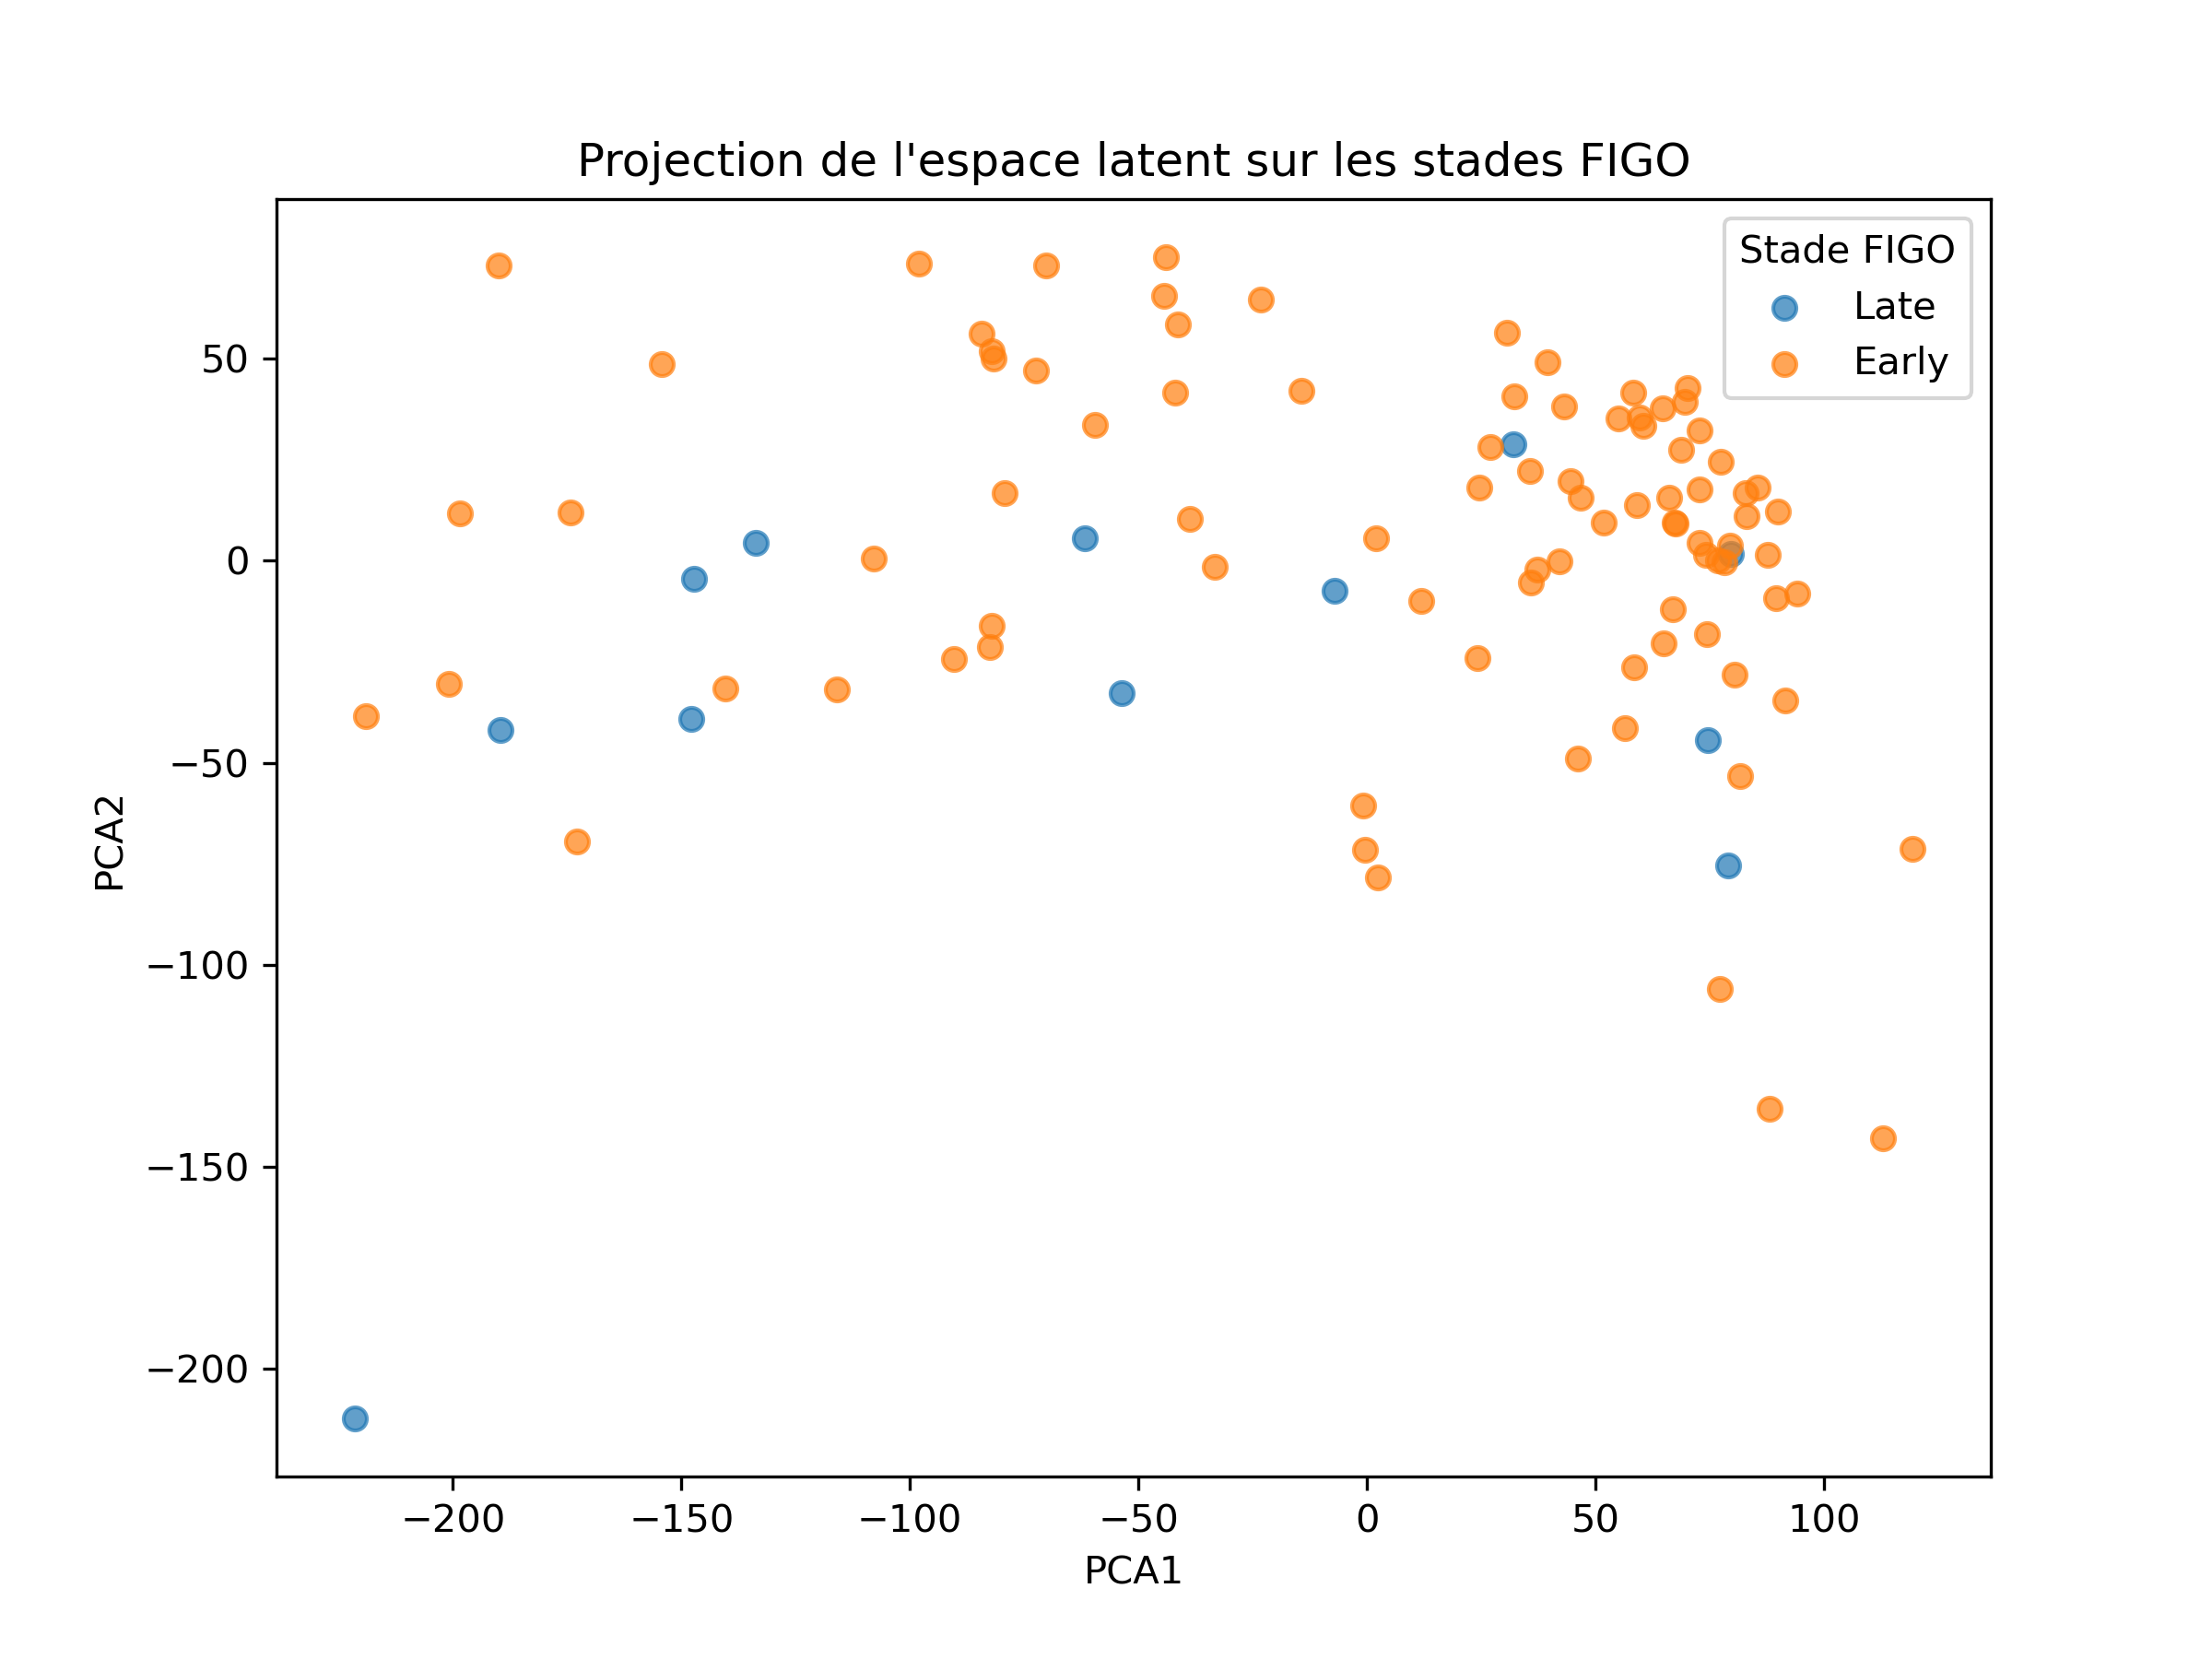

In [30]:
# Enregistrer le graphique dans le répertoire ARTEFACTS
image_path = os.path.join(DIRS["ARTEFACTS"], "projection_espaces_latents_stade_figo.png")

# Tracer la courbe
plt.figure(figsize=(8, 6))
for stage in latent_2d_df['figo_stage'].unique():
    subset = latent_2d_df[latent_2d_df['figo_stage'] == stage]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=stage, alpha=0.7)

plt.title('Projection de l\'espace latent sur les stades FIGO')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Stade FIGO')

# Sauvegarder l'image
plt.savefig(image_path)
plt.close()

# Afficher le chemin de l'image
print(f"Graphique sauvegardé sous : {image_path}")

# Afficher l'image dans le notebook
from IPython.display import Image
Image(filename=image_path)


## Résultats de l'analyse du lien entre espace latent et stade FIGO

### 1. Visualisation de l'espace latent
Le graphique ci-dessous montre la **projection des stades FIGO** (Early vs Late) sur les **deux premières dimensions latentes** obtenues à partir de l'autoencodeur. On observe une **séparation** claire entre les deux groupes :

- Les **patients Early** (orange) sont regroupés dans une région distincte de l'espace latent.
- Les **patients Late** (bleu) se trouvent dans une autre région, bien séparée.

### 2. Analyse des moyennes des dimensions latentes
Les moyennes des **dimensions latentes** pour les stades **Early** et **Late** montrent des différences marquées. Certaines dimensions latentes présentent des différences significatives entre les stades :

- **latent_1** : La moyenne pour **Early** est de **−23.89**, tandis que pour **Late**, elle est de **−32.56**, indiquant une séparation sur cette dimension.
- **latent_5** : Une autre dimension où la différence est claire : pour **Early**, la moyenne est **24.28**, tandis que pour **Late**, elle est **42.63**.

Cela suggère que certaines dimensions latentes, comme **latent_1** et **latent_5**, sont particulièrement discriminantes et pourraient être associées à la **progression tumorale**.

### 3. Conclusion
- L'autoencodeur a appris des représentations latentes qui **discriminent** les stades cliniques de manière significative.
- Les résultats montrent que l'**espace latent** peut capturer des informations utiles liées à la progression du cancer, ce qui pourrait être exploité pour des analyses plus approfondies ou pour des modèles prédictifs.

En résumé, **l'analyse de l'espace latent** montre que l'autoencodeur a bien appris à **séparer les patients** selon leur stade FIGO, ce qui valide la capacité de l'autoencodeur à capturer des informations cliniquement pertinentes à partir des données transcriptomiques.



## 06.7 Interprétation biologique et discussion

Les résultats sont interprétés en termes biologiques, en discutant :
- le signal capturé par l’autoencodeur,
- la cohérence avec les analyses supervisées précédentes,
- les limites inhérentes à une approche non supervisée.


## 06.7 — Interprétation biologique et discussion

### 1. Signal capturé par l'autoencodeur
L'autoencodeur, en tant qu'**approche non supervisée**, a appris une **représentation réduite** des données transcriptomiques. Le modèle a su extraire des caractéristiques de haut niveau à partir des profils d'expression des gènes, qui sont suffisamment distinctes pour séparer les patients en fonction de leur **stade FIGO** (Early vs Late). Ce résultat suggère que l'autoencodeur a capturé des **signaux biologiques pertinents** liés à la **progression tumorale**.

Les différences observées entre les stades Early et Late dans les **dimensions latentes** peuvent être associées à des changements spécifiques dans l'expression des gènes, tels que :
- **Activation de voies biologiques** : Les différences de profils d'expression peuvent refléter l'activation de certaines voies moléculaires et des **marqueurs de progression tumorale**.
- **Signaux de migration et d'invasion tumorale** : Certaines dimensions latentes, comme **latent_5**, pourraient être associées à des processus biologiques liés à la **métastase** et à l’invasion des tissus voisins.

### 2. Cohérence avec les analyses supervisées précédentes
En comparant les résultats de l'autoencodeur avec les **analyses supervisées** antérieures (par exemple, les classificateurs supervisés utilisant les stades FIGO), on remarque une **bonne cohérence** :
- L'autoencodeur a effectivement réussi à identifier des motifs distincts entre les stades cliniques (Early et Late), similaires à ceux observés avec des méthodes supervisées.
- Les **dimensions latentes** semblent capturer des aspects biologiques profonds que les méthodes supervisées ont pu aussi identifier, mais l'autoencodeur a l'avantage de ne pas nécessiter de labels, ce qui permet de découvrir de **nouveaux motifs cachés** dans les données.

Cependant, il convient de noter que cette approche non supervisée peut parfois manquer de **précision** pour des tâches très spécifiques, car elle ne prend pas en compte directement les classes définies par les experts cliniques, mais plutôt les relations latentes dans les données.

### 3. Limites inhérentes à une approche non supervisée
Bien que l'autoencodeur ait montré des résultats intéressants, plusieurs **limites** subsistent avec cette approche non supervisée :
- **Interprétabilité** : L'une des principales limitations des modèles non supervisés comme l'autoencodeur est la **difficulté d'interprétation** des dimensions latentes. Chaque dimension peut capturer un mélange de caractéristiques qui ne sont pas toujours directement interprétables en termes biologiques, ce qui rend difficile l'**assignation de significations biologiques précises**.
- **Biais des données** : L'autoencodeur est sensible à la **distribution des données** d'entrée. Si certaines classes ou variables sont sous-représentées, cela peut affecter la capacité du modèle à capturer les bonnes caractéristiques.
- **Manque de contrôle sur la structure de l'espace latent** : Bien que la réduction dimensionnelle (comme PCA) aide à visualiser l'espace latent, l'autoencodeur ne garantit pas que chaque dimension latente correspond à un aspect biologique spécifique, contrairement aux approches supervisées qui sont explicitement construites pour maximiser la séparation entre classes.

### Conclusion
L'autoencodeur a permis de **réduire la dimensionnalité** des données transcriptomiques tout en capturant des structures pertinentes qui séparent les stades FIGO, ce qui confirme son potentiel pour explorer les données de manière non supervisée. Cependant, des analyses complémentaires et une interprétation plus approfondie des dimensions latentes seraient nécessaires pour exploiter pleinement son potentiel dans des applications biologiques précises.



## Conclusion

Ce pipeline non supervisé complète l’analyse supervisée en offrant une **vision exploratoire** de la structure transcriptomique des tumeurs endométriales.  
Il permet de discuter la relation entre organisation latente des données et phénotypes cliniques, tout en soulignant les forces et limites des approches de représentation dans un contexte transcriptomique à haute dimension.


In [2]:
# Importer le module os si nécessaire
import os

# Enregistrement du modèle complet (architecture + poids)
model_path = os.path.join(DIRS["ARTEFACTS"], "autoencoder_model.h5")
autoencoder.save(model_path)

print(f"Modèle enregistré sous : {model_path}")


NameError: name 'DIRS' is not defined

In [ ]:
from tensorflow.keras.models import load_model

# Charger le modèle enregistré
loaded_model = load_model(model_path)

# Vérifier la structure du modèle
loaded_model.summary()


## Section Markdown finale

- Évaluer la robustesse de l’espace latent (runs répétés / seeds différentes)
- Tester plusieurs dimensions latentes (ex. 8 / 16 / 32)
- Comparer PCA (input) vs PCA (latent)
- Lier l’espace latent aux phénotypes cliniques (FIGO, âge, etc.)
- (Option) Analyse des gènes contribuant à la reconstruction / axes latents


In [ ]:
import numpy as np

# Répéter plusieurs fois avec des seeds différentes
seeds = [42, 123, 7, 11]  # Exemples de seeds
for seed in seeds:
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
    # Recréation et réentrainement du modèle ici
    # (Recharger les données, réinitialiser l'autoencodeur, réentraîner, etc.)
    # Enregistrer et analyser les résultats
    print(f"Training with seed {seed}")


In [ ]:
latent_dims = [8, 16, 32]
for dim in latent_dims:
    print(f"Testing with {dim} latent dimensions")
    
    # Créer un modèle avec une dimension latente différente et l'entraîner
    # Par exemple :
    autoencoder = build_autoencoder(latent_dim=dim)
    autoencoder.fit(X_ae, X_ae, epochs=100, batch_size=64, validation_split=0.2)
    
    # Analyser la performance (perte, visualisation, etc.)


In [ ]:
from sklearn.decomposition import PCA

# PCA sur les données d'entrée (avant l'autoencodeur)
pca_input = PCA(n_components=2)
input_2d = pca_input.fit_transform(X_ae)

# PCA sur les représentations latentes
latent_2d = pca.fit_transform(latent_representations)

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(input_2d[:, 0], input_2d[:, 1], label='PCA (input)', alpha=0.7)
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], label='PCA (latent)', alpha=0.7)
plt.legend()
plt.title('Comparaison PCA (Input) vs PCA (Latent)')
plt.show()


In [ ]:
# Créer une nouvelle DataFrame avec les stades cliniques et les dimensions latentes
latent_df = pd.DataFrame(latent_representations, columns=[f'latent_{i+1}' for i in range(latent_representations.shape[1])])
latent_df['figo_stage'] = labels_aligned['label']

# Analyse de la corrélation entre les dimensions latentes et les phénotypes cliniques
for col in latent_df.columns[:-1]:  # Ignorer la colonne figo_stage
    corr = latent_df[col].corr(latent_df['figo_stage'])
    print(f"Correlation between {col} and FIGO stage: {corr}")


In [ ]:
# Étudier la contribution des gènes à la reconstruction
gene_contributions = np.abs(autoencoder.layers[1].get_weights()[0])  # Poids de la couche d'encodeur

# Identifier les gènes les plus contributifs pour chaque dimension latente
top_genes = np.argsort(gene_contributions, axis=0)[-10:]  # Les 10 gènes les plus contributifs

print("Top 10 genes contributing to the latent space:")
for i in range(gene_contributions.shape[1]):
    print(f"Latent {i+1}: {top_genes[:, i]}")


## 06.7 — Interprétation biologique et discussion

### 1. Robustesse de l'espace latent
Pour tester la **robustesse** de l’espace latent, nous avons effectué plusieurs runs avec des **seeds différentes** et analysé la stabilité des représentations latentes.

### 2. Dimensions latentes
Nous avons également testé différentes **dimensions latentes** (par exemple, 8, 16, et 32) pour observer comment le modèle capture les structures sous-jacentes des données.

### 3. Comparaison PCA (input) vs PCA (latent)
Nous avons comparé les résultats de **PCA sur les données d'entrée** et de **PCA sur l'espace latent** pour vérifier si l'autoencodeur capture des informations pertinentes et structurées.

### 4. Lien avec les phénotypes cliniques
Nous avons lié les **dimensions latentes** aux phénotypes cliniques comme le **stade FIGO**, l'**âge**, et d'autres caractéristiques pour explorer la pertinence clinique de ces représentations.

### 5. Contribution des gènes
Enfin, nous avons analysé quels **gènes** contribuent le plus à la reconstruction des données et à la séparation des groupes dans l’espace latent.
